# 07 - Detector Comparison

Compare different segmentation algorithms on the same data.

## What You'll Learn
- Available detection algorithms
- How to switch between detectors
- Performance and accuracy comparison
- When to use which detector

## Available Detectors

| Detector | Description | Best For |
|----------|-------------|----------|
| `sliding_window` | Original algorithm, window-based | General use, interpretable |
| `bottom_up` | Merge-based segmentation | Noisy data, target segment count |
| `pelt` | PELT via ruptures (optional) | Optimal segmentation, large data |

## Setup

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from trend_classifier import Segmenter, list_detectors

warnings.filterwarnings("ignore")

# Check available detectors
print("Available detectors:", list_detectors())

Available detectors: ['sliding_window', 'bottom_up', 'pelt']


## Generate Test Data

We'll create synthetic data with clear trend changes to compare algorithms.

In [2]:
np.random.seed(42)

# Create data with 4 distinct trends
n_points = 500
noise_level = 2.0

# Trend 1: Rising (0-100)
t1 = np.linspace(0, 30, 100) + np.random.normal(0, noise_level, 100)
# Trend 2: Flat (100-200)
t2 = 30 + np.random.normal(0, noise_level, 100)
# Trend 3: Falling (200-350)
t3 = np.linspace(30, 10, 150) + np.random.normal(0, noise_level, 150)
# Trend 4: Rising steep (350-500)
t4 = np.linspace(10, 50, 150) + np.random.normal(0, noise_level, 150)

y = np.concatenate([t1, t2, t3, t4])
x = np.arange(len(y), dtype=np.float64)

# True change points
true_breakpoints = [100, 200, 350]

print(f"Data: {len(y)} points with {len(true_breakpoints)} true change points")

Data: 500 points with 3 true change points


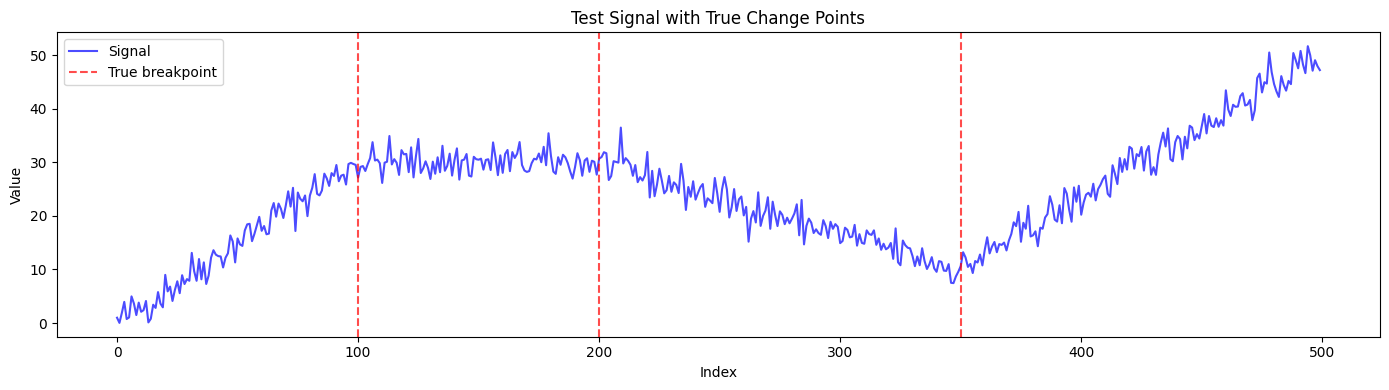

In [3]:
# Visualize the data with true breakpoints
plt.figure(figsize=(14, 4))
plt.plot(x, y, 'b-', alpha=0.7, label='Signal')
for bp in true_breakpoints:
    plt.axvline(x=bp, color='red', linestyle='--', alpha=0.7, label='True breakpoint' if bp == true_breakpoints[0] else '')
plt.title("Test Signal with True Change Points")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

## Compare Detectors

Let's run each available detector on the same data.

In [4]:
results = {}

# 1. Sliding Window Detector (default)
seg_sw = Segmenter(x=x, y=y, detector="sliding_window", detector_params={"n": 40, "alpha": 2.0})
seg_sw.calculate_segments()
results["sliding_window"] = {
    "segments": seg_sw.segments,
    "n_segments": len(seg_sw.segments),
    "error": seg_sw.calc_area_outside_trend(),
}

# 2. Bottom-Up Detector
seg_bu = Segmenter(x=x, y=y, detector="bottom_up", detector_params={"max_segments": 10})
seg_bu.calculate_segments()
results["bottom_up"] = {
    "segments": seg_bu.segments,
    "n_segments": len(seg_bu.segments),
    "error": seg_bu.calc_area_outside_trend(),
}

# 3. PELT Detector (if available)
if "pelt" in list_detectors():
    seg_pelt = Segmenter(x=x, y=y, detector="pelt", detector_params={"penalty": 10})
    seg_pelt.calculate_segments()
    results["pelt"] = {
        "segments": seg_pelt.segments,
        "n_segments": len(seg_pelt.segments),
        "error": seg_pelt.calc_area_outside_trend(),
    }

print("Results Summary:")
print("-" * 50)
for name, data in results.items():
    print(f"{name:20s}: {data['n_segments']:3d} segments, error={data['error']:.6f}")

Results Summary:
--------------------------------------------------
sliding_window      :   7 segments, error=0.066293
bottom_up           :  10 segments, error=0.065144
pelt                :  50 segments, error=0.062114


## Visual Comparison

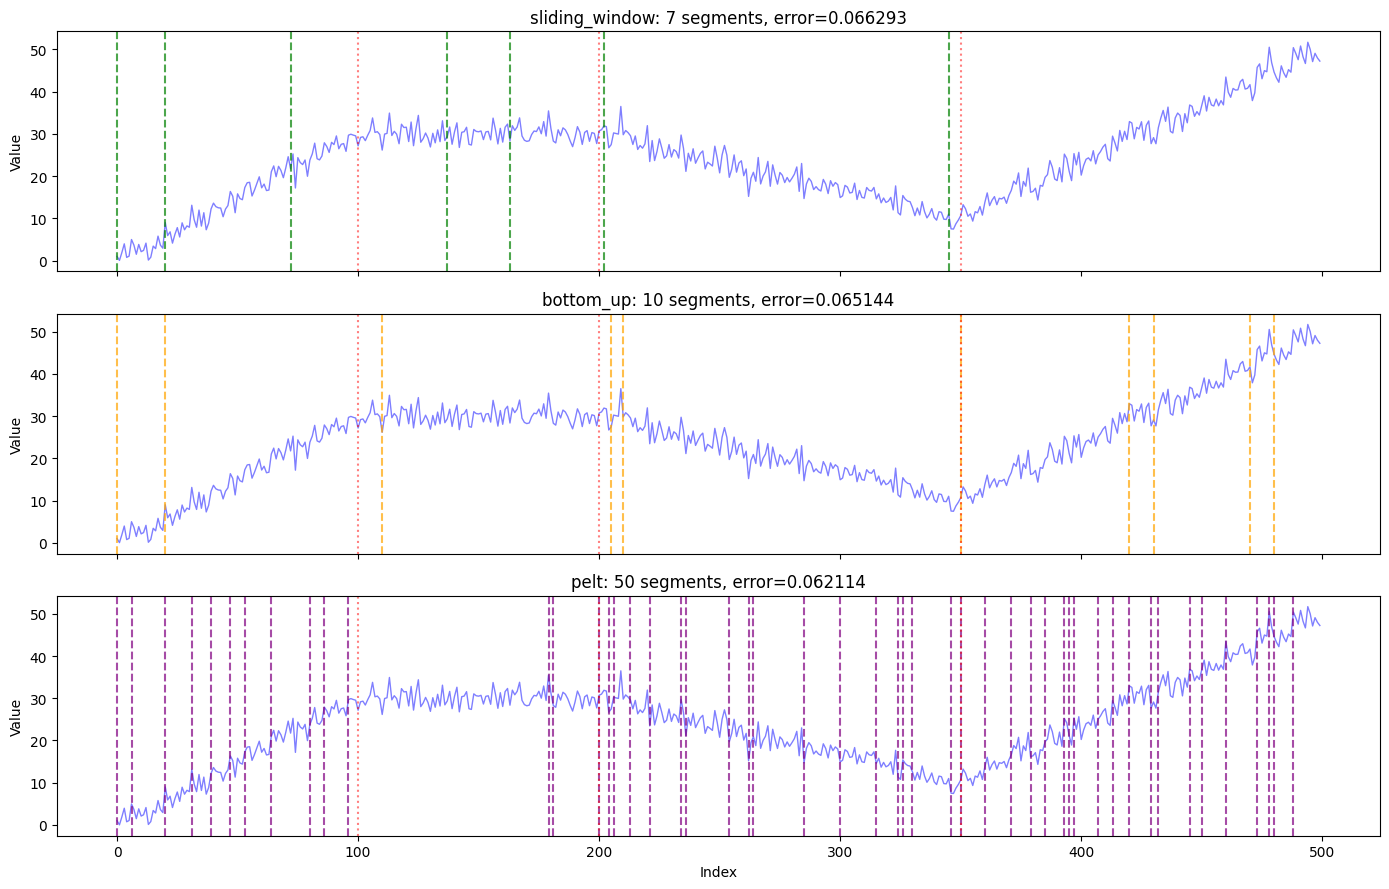

In [5]:
n_detectors = len(results)
fig, axes = plt.subplots(n_detectors, 1, figsize=(14, 3 * n_detectors), sharex=True)

if n_detectors == 1:
    axes = [axes]

colors = {"sliding_window": "green", "bottom_up": "orange", "pelt": "purple"}

for ax, (name, data) in zip(axes, results.items()):
    ax.plot(x, y, 'b-', alpha=0.5, linewidth=1)
    
    # Plot segment boundaries
    for seg in data["segments"]:
        ax.axvline(x=seg.start, color=colors.get(name, 'gray'), linestyle='--', alpha=0.7)
    
    # Plot true breakpoints
    for bp in true_breakpoints:
        ax.axvline(x=bp, color='red', linestyle=':', alpha=0.5)
    
    ax.set_title(f"{name}: {data['n_segments']} segments, error={data['error']:.6f}")
    ax.set_ylabel("Value")

axes[-1].set_xlabel("Index")
plt.tight_layout()
plt.show()

## Breakpoint Accuracy

How close are detected breakpoints to the true ones?

In [6]:
def evaluate_breakpoints(segments, true_bps, tolerance=20):
    """Evaluate breakpoint detection accuracy."""
    detected_bps = [s.start for s in segments[1:]]  # Skip first segment start
    
    # Find matches within tolerance
    matches = 0
    for true_bp in true_bps:
        for det_bp in detected_bps:
            if abs(true_bp - det_bp) <= tolerance:
                matches += 1
                break
    
    precision = matches / len(detected_bps) if detected_bps else 0
    recall = matches / len(true_bps) if true_bps else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "detected": len(detected_bps),
        "true": len(true_bps),
        "matches": matches,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

print("Breakpoint Detection Accuracy (tolerance=20):")
print("-" * 60)
print(f"{'Detector':<20} {'Detected':>10} {'Matches':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-" * 60)

for name, data in results.items():
    metrics = evaluate_breakpoints(data["segments"], true_breakpoints)
    print(f"{name:<20} {metrics['detected']:>10} {metrics['matches']:>10} "
          f"{metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1']:>10.2f}")

Breakpoint Detection Accuracy (tolerance=20):
------------------------------------------------------------
Detector               Detected    Matches  Precision     Recall         F1
------------------------------------------------------------
sliding_window                6          2       0.33       0.67       0.44
bottom_up                     9          3       0.33       1.00       0.50
pelt                         49          3       0.06       1.00       0.12


## Accuracy Summary Table

Combined metrics for all detectors:

In [7]:
# Build accuracy summary table
accuracy_data = []
for name, data in results.items():
    metrics = evaluate_breakpoints(data["segments"], true_breakpoints)
    accuracy_data.append({
        "Detector": name,
        "Segments": data["n_segments"],
        "Fit Error": f"{data['error']:.6f}",
        "Precision": f"{metrics['precision']:.2f}",
        "Recall": f"{metrics['recall']:.2f}",
        "F1 Score": f"{metrics['f1']:.2f}",
    })

accuracy_df = pd.DataFrame(accuracy_data)
print("\n=== ACCURACY COMPARISON ===\n")
print(accuracy_df.to_string(index=False))


=== ACCURACY COMPARISON ===

      Detector  Segments Fit Error Precision Recall F1 Score
sliding_window         7  0.066293      0.33   0.67     0.44
     bottom_up        10  0.065144      0.33   1.00     0.50
          pelt        50  0.062114      0.06   1.00     0.12


## Performance Benchmark

Compare execution time across different data sizes.

In [8]:
def benchmark_detector(detector_name, x_data, y_data, params):
    """Benchmark a single detector."""
    start = time.perf_counter()
    seg = Segmenter(x=x_data, y=y_data, detector=detector_name, detector_params=params)
    seg.calculate_segments()
    elapsed = time.perf_counter() - start
    return elapsed * 1000  # Convert to ms

# Data sizes to test
sizes = [500, 2000, 10000]

# Default parameters for each detector
default_params = {
    "sliding_window": {"n": 50},
    "bottom_up": {"max_segments": 20},
    "pelt": {"penalty": 20},
}

# Run benchmarks
benchmark_results = {name: [] for name in list_detectors()}

print("Running performance benchmarks...")
for size in sizes:
    # Generate test data
    test_x = np.arange(size, dtype=np.float64)
    test_y = np.cumsum(np.random.randn(size)) + np.sin(test_x / 100) * 10
    
    for detector_name in list_detectors():
        params = default_params.get(detector_name, {})
        # Average over 3 runs for stability
        times = [benchmark_detector(detector_name, test_x, test_y, params) for _ in range(3)]
        avg_time = np.mean(times)
        benchmark_results[detector_name].append(avg_time)
    
    print(f"  {size} points: done")

Running performance benchmarks...
  500 points: done
  2000 points: done
  10000 points: done


### Performance Results Table

In [9]:
# Build performance table
perf_data = []
for detector_name in list_detectors():
    row = {"Detector": detector_name}
    for i, size in enumerate(sizes):
        row[f"{size} pts"] = f"{benchmark_results[detector_name][i]:.1f} ms"
    perf_data.append(row)

perf_df = pd.DataFrame(perf_data)
print("\n=== PERFORMANCE COMPARISON ===\n")
print(perf_df.to_string(index=False))


=== PERFORMANCE COMPARISON ===

      Detector  500 pts  2000 pts   10000 pts
sliding_window   1.6 ms    4.7 ms     24.2 ms
     bottom_up 342.0 ms 5610.0 ms 137476.3 ms
          pelt  70.0 ms  395.5 ms   4917.1 ms


### Performance Visualization

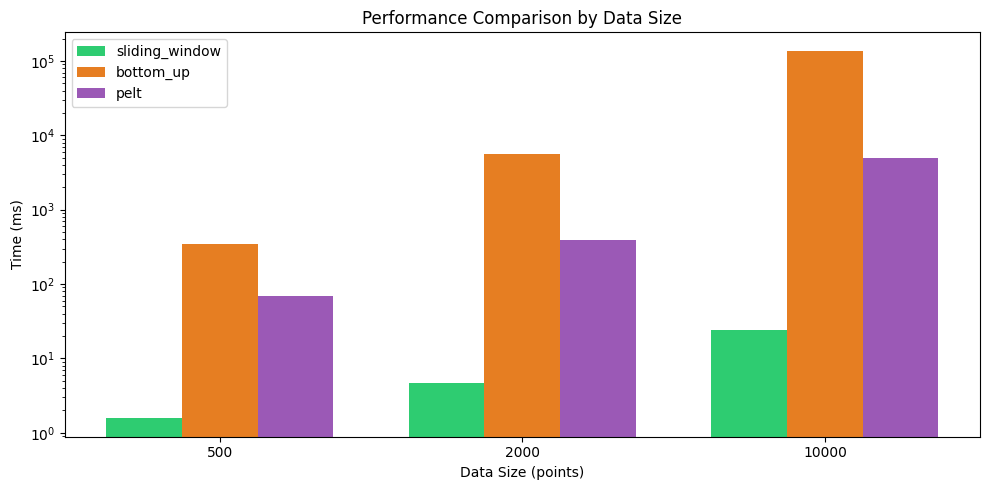

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.25
x_positions = np.arange(len(sizes))
colors = {"sliding_window": "#2ecc71", "bottom_up": "#e67e22", "pelt": "#9b59b6"}

for i, detector_name in enumerate(list_detectors()):
    offset = (i - len(list_detectors()) / 2 + 0.5) * bar_width
    ax.bar(
        x_positions + offset,
        benchmark_results[detector_name],
        bar_width,
        label=detector_name,
        color=colors.get(detector_name, "gray"),
    )

ax.set_xlabel("Data Size (points)")
ax.set_ylabel("Time (ms)")
ax.set_title("Performance Comparison by Data Size")
ax.set_xticks(x_positions)
ax.set_xticklabels([str(s) for s in sizes])
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()

## When to Use Which Detector

### Sliding Window (`sliding_window`)
- **Pros**: Interpretable, configurable sensitivity, good for most cases
- **Cons**: Sensitive to window size, may miss abrupt changes
- **Best for**: General use, when you need explainability
- **Complexity**: O(n)

### Bottom-Up (`bottom_up`)
- **Pros**: Control exact segment count, good for noisy data
- **Cons**: Computationally heavier O(n²), may not find optimal breakpoints
- **Best for**: When you know desired segment count, noisy signals

### PELT (`pelt`)
- **Pros**: Optimal segmentation, fast O(n), well-studied algorithm
- **Cons**: Requires ruptures library, penalty tuning needed
- **Best for**: Large datasets, when optimal segmentation matters

## Recommendation Summary

| Use Case | Recommended Detector |
|----------|---------------------|
| Quick analysis | `sliding_window` |
| Exact segment count needed | `bottom_up` |
| Large dataset (>10k points) | `pelt` |
| Interpretable results | `sliding_window` |
| Optimal change point detection | `pelt` |

## Using Custom Detector Instances

For more control, create detector instances directly:

In [11]:
from trend_classifier.detectors import SlidingWindowDetector, BottomUpDetector

# Custom sliding window
detector = SlidingWindowDetector(
    n=50,
    overlap_ratio=0.4,
    alpha=1.5,
    beta=None,  # Disable offset checking
)

seg = Segmenter(x=x, y=y, detector=detector)
result = seg.fit_detect()

print(f"Custom detector found {len(result.segments)} segments")
print(f"Algorithm metadata: {result.metadata}")

Custom detector found 5 segments
Algorithm metadata: {'algorithm': 'sliding_window', 'n': 50, 'overlap_ratio': 0.4, 'alpha': 1.5, 'beta': None}


## Conclusion

You've learned:
- How to use different detection algorithms
- How to compare their results visually and quantitatively
- Performance characteristics of each algorithm
- When to choose each algorithm

**Recommendation**: Start with `sliding_window` for most cases. Use `pelt` for
optimal results on large datasets, or `bottom_up` when you need a specific
number of segments.